In [18]:
import os
import sys
import pickle
import pandas as pd
import numpy as np
import talib as ta
from datetime import datetime, timedelta
#%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image, display_png
os.chdir('/Users/shun/PycharmProjects/crypto-onibot')

from plot.chart_creator import ChartCreator as cc
from trade_tools.trade_utils import init_exchange, calc_horizon, format_orderbook, get_orderbook_around_horizon
from trade_tools.my_api import APISim
from collections import ChainMap
from common.utils import dt2str, merge_dicts

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 1000)

In [19]:
EXCHANGE_NAME = 'bitmex'
PAIR = 'BTC/USD'
CANDLE_TYPE = '1m'
MAX_WAIT_TIME = 300
API = APISim(EXCHANGE_NAME)

In [20]:
def update_horizon(api, pair, candle_types, sinces):
    horizons = {}
    for candle_type, since in zip(candle_types, sinces):
        ohlcv = api.fetch_ohlcv(pair, candle_type, since)
        df_ohlcv = pd.DataFrame(ohlcv, columns=['unixtime', 'open', 'high', 'low', 'close', 'volume'])
        # 未確定足は含めない
        df_ohlcv = df_ohlcv.iloc[:-1]
        df_ohlcv['unixtime'] = df_ohlcv['unixtime'] / 1000
        df_ohlcv.index = df_ohlcv.unixtime.map(lambda x: datetime.fromtimestamp(x))
        tmp = calc_horizon(df_ohlcv, min_whisker_len=0, threshold_whisker_diff=0)
        horizons = merge_dicts(tmp, horizons)
    return horizons

In [21]:
# 水平線を引く
candle_types = ['1m', '5m', '1h']
sinces = [(datetime.now() - timedelta(hours=1)).timestamp() * 1000,
          (datetime.now() - timedelta(hours=6)).timestamp() * 1000,
          (datetime.now() - timedelta(days=1)).timestamp() * 1000]
horizons = update_horizon(API, PAIR, candle_types, sinces)

In [22]:
since =  (datetime.now() - timedelta(hours=1)).timestamp() * 1000
ohlcv = API.fetch_ohlcv(PAIR, CANDLE_TYPE, since, limit=500)
df_ohlcv = pd.DataFrame(ohlcv, columns=['unixtime', 'open', 'high', 'low', 'close', 'volume'])
# 未確定足は含めない
df_ohlcv = df_ohlcv.iloc[:-1]
df_ohlcv['unixtime'] = df_ohlcv['unixtime'] / 1000
df_ohlcv.index = df_ohlcv.unixtime.map(lambda x: datetime.fromtimestamp(x))

3912.0
3897.5
3880.0
3881.0
3889.5
3884.5


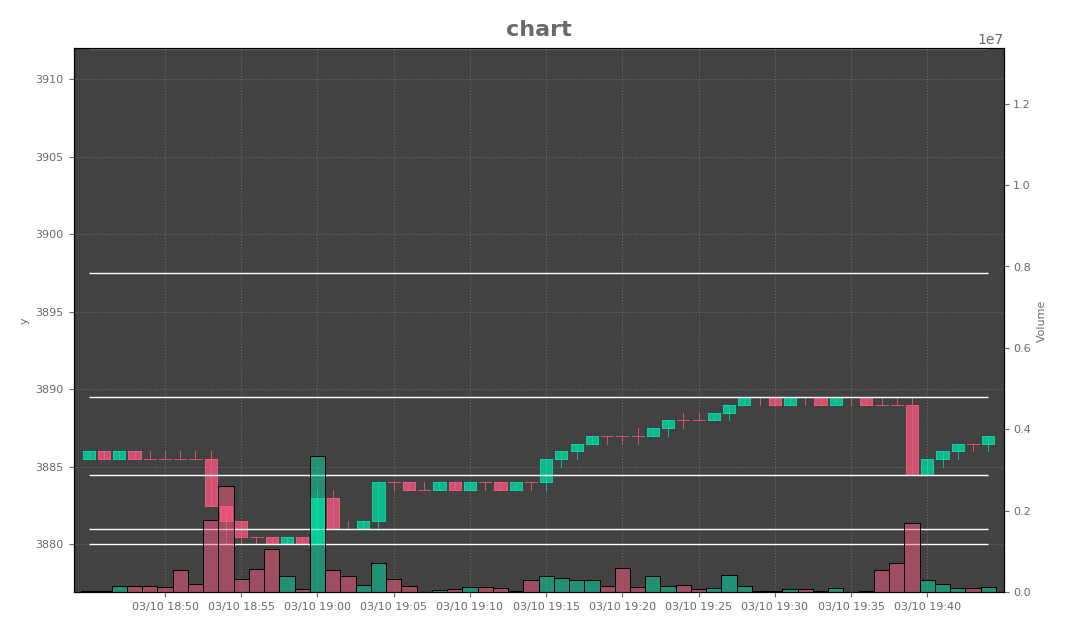

In [23]:
#---------------------------------------------------------------------------
# レイアウトカスタマイズ
#---------------------------------------------------------------------------
cc.initialize()                              # 設定データ初期化
cc.settings["frontcolor"] = "DimGray"        # 前景色
cc.settings["backcolor"]  = "#424242"        # 背景色
cc.settings["bar"]["up_color"]   = "#01DFA5" # 陽線色
cc.settings["bar"]["down_color"] = "#FA5882" # 陰線色

#---------------------------------------------------------------------------
# メインチャート(ax:0)
#---------------------------------------------------------------------------
cc.add_subchart(ax=0, grid=True)
# ローソクバー設定(OHLCV)
cc.set_ohlcv_df(df_ohlcv)
# 水平線
for h in horizons.keys():
    print(h)
    cc.set_hline(h, ax=0, color="white", width=1.0, name=h)

#---------------------------------------------------------------------------
# チャート生成
#---------------------------------------------------------------------------
file_path = "data/chart_sample1"
cc.create_chart(file_path + ".png", "png")

# チャート画像表示
display_png(Image(file_path + '.png'))